## How to simulate extra-tidal stars and binaries of globular clusters with Corespray.

### STEP 0: Import the necessary Python packages. 

$\texttt{corespray}$ can be downloaded at: https://github.com/webbjj/corespray. 

$\texttt{galpy}$ (Bovy 2015) can be downloaded at: https://docs.galpy.org/en/v1.8.0/. 


In [1]:
# Import corespray:
from corespray import corespraydf,load_galpy_potential

# Import galpy packages:
from galpy.potential import MWPotential2014
from galpy.potential import KingPotential
from galpy.util import conversion
from galpy.orbit import Orbit

# Import other necessary Python packages:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from matplotlib import animation


from IPython.display import HTML
%matplotlib inline

### STEP 1: Load in the specific parameters for your GC of interest:
Spatial, kinematic and orbital parameters for most Galactic GCs can be found in the Baumgardt & Hilker (2018) catalogue. This catalogue is accessible at: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/. 

For this example, we simulate extra-tidal stars and binaries of M3. 

In [2]:
#Name of Galactic Globular Cluster from which to simulate core ejection or a Galpy orbit instance
gcname ='M3' 
#Potentional to be used for orbit integration (default: MWPotential2014)
potential = load_galpy_potential()  # Galactic potential model
#average 1D velocity in the core (default: 0 km/s)
mu0 = 0. 
#avarege 1D velocity disperions in the core (default 10.0 km/s)
sig0 = 7.6
#escape velocity from the core (default: 10.0 km/s)
vesc0 = 30.0  # Central escape velocity [km/s]
#core density (default: 1 Msun/pc^3)
rho0 = 10.0**3.67
#globular cluster mass - needed if cluster's potential is to be included in orbit integration of escapers (default: None)
mgc = 4.06e5  # Mass [solar masses]
#half-mass radius of globular cluster (assuming Plummer potential) or tidal radius of globular cluster (assuming King potential) (default: None)
rgc = 127.28/1000.0  # Tidal radius of GC [kpc]
#King central potential parameter (default: None, which results in cluster potential taken to be a Plummer)
W0 = 8.61469762517307 
#minimum stellar mass in core (default (0.1 Msun))
mmin = 0.1 
#maximum stellar mass in the core (default: 1.4 Msun)
mmax = 1.4
#slope of the stellar mass function in the core (default: -1.35)
alpha = -1.35 #(Salpeter 1955)
#If emin and emax are None, assume limits are between twice the hard-soft boundary and twice the contact boundary between two solar mass stars
#minimum binary energy (default: None)
emin=None
#maximum binary energy (default: None)
emax=None
#galpy length scaling parameter (default: 8.)
ro = 8. #radius of the solar circle 
#galpy veocicity scaling parameter (default: 220.)
vo = 220. #circular orbit velocity at the solar circle
#exponenet for calculating probability of stellar escape from three-body system (#Equation 7.23)
#(default: -3)
q=-3

### STEP 2: Initialize a corespray instance using your previously defined parameters

In [3]:
# Initialize corespray
cspray = corespraydf(gcname, 
                     potential, 
                     mgc, rgc, W0, 
                     ro,vo)

### STEP 3: Sample core ejections along the orbit for 1000 Myr.


In [4]:
#time over which sampling begins (Myr)
tdisrupt=1000.0
#ejection rate (default 1 per Myr)
rate=1.0
#if set, nstar stars will be ejected randomly from -tdisrupt to 0 Myr. 
#Rate is recalculated. (default : None)
nstar=10
#when sampling kick velocity distribution function
#sampling range will be from 0 to npeak*vpeak, where 
#vpeak is the peak in the distribution function (default: 5)
npeak=5
#keep track of binaries that receive recoil kicks greater than 
#the cluster's escape velocity (default : False)
binaries=True

os,ob = cspray.sample_three_body(tdisrupt,rate,nstar,
                                 mu0,sig0,vesc0,rho0,
                                 mmin,mmax,alpha,
                                 emin=emin,emax=emax,
                                 q=q,
                                 npeak=npeak,binaries=binaries)

### STEP 4: Extract parameters for the SINGLE escapers:

In [5]:
t_esc = cspray.tesc  # [Myr] in the past that star escaped
v_esc = cspray.vesc  # [km/s] kick velocity that star received
mstar = cspray.mstar # [Msol] mass of kicked star

### STEP 5: Extract parameters for all BINARY stars:

In [6]:
# Would tesc of binary be same as escaper star?
v_esc_b = cspray.vescb  # [km/s] kick velocity that star received
m_b1 = cspray.mb1  # [Msol] mass of primary star
m_b2 = cspray.mb2  # [Msol] mass of secondary star
m_b_tot = m_b1 + m_b2  # [Msol]

# bindx is a boolean that gives indxs of binaries that escaped the cluster: 
bin_esc = cspray.bindx
print("{}/{} binaries escaped {}.".format(len(ob[bin_esc]), len(ob), gcname))

0/10 binaries escaped M3.


#### Explore some parameter spaces of your simulated extra-tidal stars and binaries!
-- Note the cluster's orbit instance is set to cspray.o

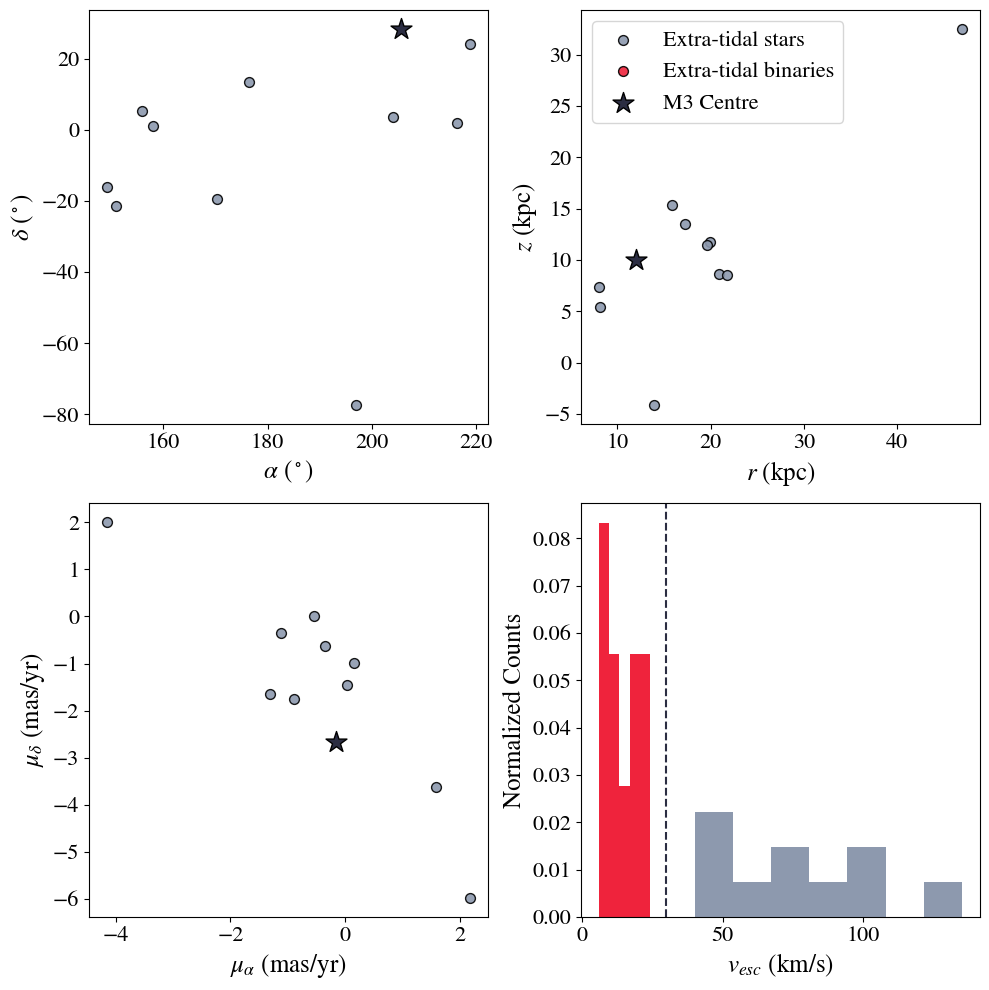

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# RA vs Dec positions:
ax[0, 0].scatter(os.ra(), os.dec(), marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[0, 0].scatter(ob.ra()[bin_esc], ob.dec()[bin_esc], marker='o', s=50, edgecolor='black', c='#ef233c', alpha=0.9) 
ax[0, 0].scatter(cspray.o.ra(), cspray.o.dec(), marker='*', s=250, edgecolor='black', c='#2b2d42')
ax[0, 0].set_xlabel(r"$\alpha$ ($^\circ $)", fontsize=18)
ax[0, 0].set_ylabel(r"$\delta$ ($^\circ $)", fontsize=18)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].tick_params(axis='both', which='minor', labelsize=16)

# R vs z positions:
ax[0, 1].scatter(os.r(), os.z(), marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9, label='Extra-tidal stars') 
ax[0, 1].scatter(ob.r()[bin_esc], ob.z()[bin_esc], marker='o', s=50, edgecolor='black', c='#ef233c', alpha=0.9, label='Extra-tidal binaries') 
ax[0, 1].scatter(cspray.o.r(), cspray.o.z(), marker='*', s=250, edgecolor='black', c='#2b2d42', label='M3 Centre')
ax[0, 1].set_xlabel(r"$r$ (kpc)", fontsize=18)
ax[0, 1].set_ylabel(r"$z$ (kpc)", fontsize=18)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[0, 1].legend(fontsize=16)

# Proper motion:
ax[1, 0].scatter(os.pmra(), os.pmdec(), marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[1, 0].scatter(ob.pmra()[bin_esc], ob.pmdec()[bin_esc], marker='o', s=50, edgecolor='black', c='#ef233c', alpha=0.9) 
ax[1, 0].scatter(cspray.o.pmra(), cspray.o.pmdec(), marker='*', s=250, edgecolor='black', c='#2b2d42')
ax[1, 0].set_xlabel(r"$\mu_{\alpha}$ (mas/yr)", fontsize=18)
ax[1, 0].set_ylabel(r"$\mu_{\delta}$ (mas/yr)", fontsize=18)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].tick_params(axis='both', which='minor', labelsize=16)

# Escape velocities:
ax[1, 1].hist(v_esc, bins=7, color='#8d99ae', density=True)
ax[1, 1].hist(v_esc_b, bins=5, color='#ef233c', density=True)
ax[1, 1].axvline(vesc0, ls='--', c='#2b2d42')
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[1, 1].set_xlabel(r"$v_{esc}$ (km/s)", fontsize=18)
ax[1, 1].set_ylabel("Normalized Counts", fontsize=18)

fig.tight_layout()
plt.show()

#### Animate the ejection of stars from the cluster's core

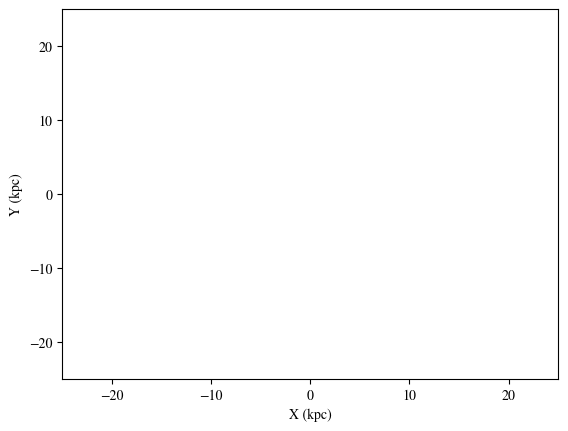

In [8]:
#frames - number of frames to use for animation (default:100)
#interval - time intercal between frames (default: 50 Myr)  
#xlim - xlimits for figure  
#ylim - ylimts for figure

cspray.animate(frames=100,interval=50,xlim=(-25,25),ylim=(-25,25))

In [9]:
HTML(cspray.anim.to_jshtml())


### Create Snapshot

In [10]:
#Output present day positions, velocities, escape times, and escape velocities of stars
#filename: file name to write data to (default: corespray.dat)
#filenameb: file name to write binary data to (default: corespray.dat)
cspray.snapout(filename='corespray_threebody.dat',filenameb='corespray_threebody_binaries.dat')